# Maximizing Life Satisfaction by Applying Machine Learning to a Data Journal

- Author: Aaron Gillespie  
- Date: 2025-04-20

> [!tldr]
> A somewhat tongue-in-cheek project utilizing machine learning and business intelligence tools against **12 years of quantified self data** to determine, once and for all, what contributes to a satisfying life. Compiled for fun, but also as part of Northwest Missouri's CSIS 44670 Final. 

This repository is being created in service of Northwest Missouri State University 44608 Module 6 - Exploratory Data Analysis. It will accomplish the following objectives from the module:

- demonstrate skills with Jupyter, pandas, Seaborn and popular tools for data analytics
- utilize machine learning to develop predictive models
- tell a data story and visually present findings in a clear and engaging manner

And, in my case, will include one additional objective:
- Utilizing my long-running quantified self project / data journal for an grad school assignment

## About the Dataset

The data gathered for this work are from many sources. The primary data sources are: 

- my long-running [Data Journal](https://aarongilly.com/Pages/Data-Journal) project
- my Oura ring
- Apple Health & various other apps

The data all represent me & my life over the past 12 years. For the purposes of machine learning, the dataset will only reach back ~8 years, as I didn't start doing my daily "**Satisfaction**" score until June, 2017. 

> [!important] **Satisfaction** is the target we'll be training against  
> Each night I rate how satisfied I am with the day's happenings on a scale from 1 to 10.  
> 10 is a perfect day, 1 is reserved for the truly horrid days.

### The Data Journal - in short:

Data Journal is a system I built to help me keep track of stuff that happens in my life. Its form has changed greatly over the past decade, but its function has remained the same: to house data about things I do. It’s a default place to make note of things that might not otherwise have a place. I’ve tracked lots of different things over the years.

![data journal gist](assets/dj.png)

Building and maintaining a Data Journal is an easy and incredible habit to get into. I think everyone could benefit from having one of their own, tracking the things that are important to them.

For more on my Data Journal, read [this page on my personal site](https://aarongilly.com/Pages/Data-Journal).

## Section 0. Pre-work

The full version of this dataset contains a multitude of things I wouldn't want published online, so much scrubbing & pre-work was done *before* the creation of the `data/` folder.

Pre-work included sourcing data from various apps, fed by various pieces of hardware over the past decade.

![work already done](assets/pre-work.png)

The full dataset would include things like daily summaries, details about where I've gone, who I've spent time with, etc. None of those data features are present in this public-facing dataset. Thus those factors will not be considered in this model.

While I was doing this sanitization - to facilitate the machine learning model I converted **categorical** data to **numeric** data using a form of **one-hot** encoding. For example, I converted an `exercise type` column into three separate columns for each exercise type I track.

This was done by hand, and it isn't *techincally* "one" hot. For example, I could run & lift weights on the same day, which would translate to `1` in both the `Strength` and `Cardio` columns.

## Section 1. Import and Inspect the Data

Before we can do any machine learning, we have to obtain references to the data in code.

In [1052]:
# Imports.

import os

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso

from sklearn.metrics import mean_absolute_error
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error


In [1053]:
# Path to the data folder
data_folder = 'data/'

# Dictionary to store dataframes
dataframes = {}

# Read each CSV file into its own dataframe
for file in os.listdir(data_folder):
    if file.endswith('.csv'):
        file_path = os.path.join(data_folder, file)
        df_name = file.split('.')[0]  # Use the file name (without extension) as the dataframe name
        dataframes[df_name] = pd.read_csv(file_path)

# Display the names of the dataframes loaded
print(f"Loaded dataframes: {list(dataframes.keys())}")



Loaded dataframes: ['Diet', 'VO2', 'Oura', 'Hevy', 'Cardio', 'Data_Journal']


In [1054]:
# Process each dataframe to conform headers to snake_case and convert the first column to datetime
for name, df in dataframes.items():
    # Convert headers to lowercase snake_case
    df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('-', '_')
    
    # Convert the first column to datetime
    first_column = df.columns[0]
    df[first_column] = pd.to_datetime(df[first_column])
    
    # Update the dataframe in the dictionary
    dataframes[name] = df

# Display the updated headers for verification
for name, df in dataframes.items():
    print(f"{name} headers: {df.columns.tolist()}")

Diet headers: ['date', 'breakfast_calories', 'breakfast_carbs', 'breakfast_fats', 'breakfast_protein', 'lunch_calories', 'lunch_carbs', 'lunch_fats', 'lunch_protein', 'dinner_calories', 'dinner_carbs', 'dinner_fats', 'dinner_protein', 'snacks_calories', 'snacks_carbs', 'snacks_fats', 'snacks_protein', 'calories', 'carbs', 'fats', 'protein']
VO2 headers: ['date', 'vo2_est']
Oura headers: ['date', 'active_calories', 'sedentary_time', 'steps', 'activity_score', 'readiness_score', 'sleep_score', 'temperature_deviation', 'average_breath', 'average_heart_rate', 'average_hrv', 'awake_time', 'deep_sleep_duration', 'efficiency', 'latency', 'light_sleep_duration', 'rem_sleep_duration', 'time_in_bed', 'total_sleep_duration']
Hevy headers: ['date', 'lift_volume_lbs']
Cardio headers: ['date', 'activitytype', 'duration', 'cals_burned', 'meters']
Data_Journal headers: ['date', 'wk_day', 'day', 'week', 'month', 'quarter', 'year', 'travel', 'satisfaction', 'health', 'work_status', 'bedtime', 'wake', 's

/var/folders/hk/h6rz0nm939n_y0ssynfrg63r0000gn/T/ipykernel_19397/2360739851.py:8: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[first_column] = pd.to_datetime(df[first_column])


In [1055]:
# Check for missing values and display summary statistics for each dataframe
for name, df in dataframes.items():
    print(f"Summary for dataframe: {name}")
    missingCounts = df.isnull().sum()
    if (missingCounts > 0).any():
        print(f"Missing values in {name}:")
        print(missingCounts[missingCounts > 0])
    print("\nSummary statistics:")
    print(df.describe(include='all'))
    print("\n" + "-"*50 + "\n")

Summary for dataframe: Diet

Summary statistics:
                      date  breakfast_calories  breakfast_carbs  \
count                  144          144.000000       144.000000   
mean   2019-05-20 06:50:00          360.792361        23.260417   
min    2018-11-06 00:00:00            0.000000         0.000000   
25%    2019-02-05 00:00:00            0.000000         0.000000   
50%    2019-05-15 12:00:00          220.000000         0.000000   
75%    2019-08-19 18:00:00          637.225000        27.500000   
max    2020-01-28 00:00:00         2050.000000       301.000000   
std                    NaN          443.120202        48.328059   

       breakfast_fats  breakfast_protein  lunch_calories  lunch_carbs  \
count      144.000000         144.000000      144.000000   144.000000   
mean        31.331944          39.181944      645.668056    40.559722   
min          0.000000           0.000000        0.000000     0.000000   
25%          9.450000          14.000000        0.00000

### Reflection 1:

**What do you notice about the dataset?**

This is very much "my" dataset. I'm incredibly familiar with it. Right now I notice it's spread out amongst many data frames, which won't be helpful. Need to resolve that.

**Are there any data issues?**

There are some issues I'll address soon. Things that contain a `0.0` that should contain a `NaN` or blank value, for one. 

## Section 2. Data Exploration and Preparation

In this section we explore the data a bit further, consider how we might modify it to make the machine learning process go easier and/or produce better results, and then make those modifications. We will add some features to this dataset to give each row a "memory" of the row(s) before it, as I strongly suspect my subjective "daily satisfaction" is actually a cumulative result of the recent past few days, not just the day that receives the grade.

In [1056]:
# Start with the first dataframe in the dictionary
combined_df = dataframes['Diet']

# Merge all other dataframes into the combined dataframe on the "date" column
for key, df in dataframes.items():
    if key != 'Diet':  # Skip the first dataframe as it's already included
        combined_df = combined_df.merge(df, on='date', how='outer')

# Display the combined dataframe's info and a preview
print(combined_df.info())
print(combined_df.head(10))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3006 entries, 0 to 3005
Data columns (total 77 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   date                   3006 non-null   datetime64[ns]
 1   breakfast_calories     144 non-null    float64       
 2   breakfast_carbs        144 non-null    float64       
 3   breakfast_fats         144 non-null    float64       
 4   breakfast_protein      144 non-null    float64       
 5   lunch_calories         144 non-null    float64       
 6   lunch_carbs            144 non-null    float64       
 7   lunch_fats             144 non-null    float64       
 8   lunch_protein          144 non-null    float64       
 9   dinner_calories        144 non-null    float64       
 10  dinner_carbs           144 non-null    float64       
 11  dinner_fats            144 non-null    float64       
 12  dinner_protein         144 non-null    float64       
 13  sna

The data look good here, but given the importance of this combined dataframe for the rest of the project, I'm going to export the newly joined toegether dataset to a csv to inspect it in Excel.

In [1057]:
# Export to an output_data folder for inspection in Excel

combined_df.to_csv('output_data/combined_data.csv', index=False)

Merging the data together populated some rows for those few days wherein I failed to give myself a daily "Satisfaction" rating. This will be the target of our machine learning, so we can drop those rows.

In [1058]:
# Remove rows where the 'satisfaction' column contains no value
combined_df = combined_df.dropna(subset=['satisfaction'])

# Display the updated dataframe info
print(combined_df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 2874 entries, 0 to 3005
Data columns (total 77 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   date                   2874 non-null   datetime64[ns]
 1   breakfast_calories     143 non-null    float64       
 2   breakfast_carbs        143 non-null    float64       
 3   breakfast_fats         143 non-null    float64       
 4   breakfast_protein      143 non-null    float64       
 5   lunch_calories         143 non-null    float64       
 6   lunch_carbs            143 non-null    float64       
 7   lunch_fats             143 non-null    float64       
 8   lunch_protein          143 non-null    float64       
 9   dinner_calories        143 non-null    float64       
 10  dinner_carbs           143 non-null    float64       
 11  dinner_fats            143 non-null    float64       
 12  dinner_protein         143 non-null    float64       
 13  snacks_c

Add some features based on factors that "feel" like things that might effect the subjective rating I'd give a day.

In [1059]:
# Add a running average column for satisfaction over the previous 3 rows, excluding the current row
combined_df['satisfaction_running_avg'] = combined_df['satisfaction'].shift(1).rolling(window=3, min_periods=1).mean()

# Replace NaN values in 'satisfaction_running_avg' with the average of the column
combined_df['satisfaction_running_avg'].fillna(combined_df['satisfaction_running_avg'].mean(), inplace=True)

# Adding a workouts column that reports if any of the workouts were done
combined_df['workouts'] = combined_df[['strength', 'cardio', 'mobility']].sum(axis=1)

# Add a column to count successive zeros in the workouts column
combined_df['days_since_workout'] = combined_df['workouts'].eq(0).astype(int).groupby(combined_df['workouts'].ne(0).cumsum()).cumsum()

# Display the first few rows to verify
print(combined_df[['date', 'satisfaction', 'satisfaction_running_avg']].head(10))
print(combined_df[['date', 'strength', 'cardio', 'mobility', 'workouts']].head(10))
print(combined_df[['date', 'workouts', 'days_since_workout']].head(30))

        date  satisfaction  satisfaction_running_avg
0 2017-06-10           4.0                  6.005047
1 2017-06-11           7.0                  4.000000
2 2017-06-12           7.0                  5.500000
3 2017-06-13           7.0                  6.000000
4 2017-06-14           8.0                  7.000000
5 2017-06-15           4.0                  7.333333
6 2017-06-16           9.0                  6.333333
7 2017-06-17          10.0                  7.000000
8 2017-06-18           8.0                  7.666667
9 2017-06-19           7.0                  9.000000
        date  strength  cardio  mobility  workouts
0 2017-06-10       0.0     1.0       0.0       1.0
1 2017-06-11       0.0     1.0       0.0       1.0
2 2017-06-12       0.0     0.0       0.0       0.0
3 2017-06-13       0.0     0.0       0.0       0.0
4 2017-06-14       0.0     0.0       0.0       0.0
5 2017-06-15       0.0     0.0       0.0       0.0
6 2017-06-16       0.0     0.0       0.0       0.0
7 2017-06

/var/folders/hk/h6rz0nm939n_y0ssynfrg63r0000gn/T/ipykernel_19397/310046961.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  combined_df['satisfaction_running_avg'].fillna(combined_df['satisfaction_running_avg'].mean(), inplace=True)


We have an issue wherein some columns contain `0.0` where there should actually be a `null` or `NaN` value before I started tracking them. For example - the `ate_out`, `date_night`, and columns near that were tracked only since 2020. All data before that report a `0.0`, but they should just be *blank*. This is a case wherein I need to a correction to align with one of my system-design prinicples: 

> [Don't use absence of a signal as a signal](https://gillespedia.com/Don%E2%80%99t+use+%E2%80%9CAbsence+of+a+Signal%E2%80%9D+as+a+Signal)

In [1060]:
# Replace values with NaN for "outings" and "pains/treatments" rows where the date is before 2020-01-01
columns_to_update = ['date_night', 'ate_out', 'saw_family', 'saw_friends', 'pains', 'treatments']
combined_df.loc[combined_df['date'] < '2020-01-01', columns_to_update] = None

# Replace values with NaN for "media" rows where the date is before 2019-01-01
columns_to_update = ['book', 'tv', 'videogame', 'movie']
combined_df.loc[combined_df['date'] < '2019-01-01', columns_to_update] = None

We'll do one more sanity check export to CSV to check everything before we move on to the machine learning portion.

In [1061]:
# Export to an output_data folder for inspection in Excel

combined_df.to_csv('output_data/combined_data_with_features.csv', index=False)

After reviewing that, all's well for the most part. Now I'm going to produce some pretty visuals to give you, dear reader, some ideas of what's in here.

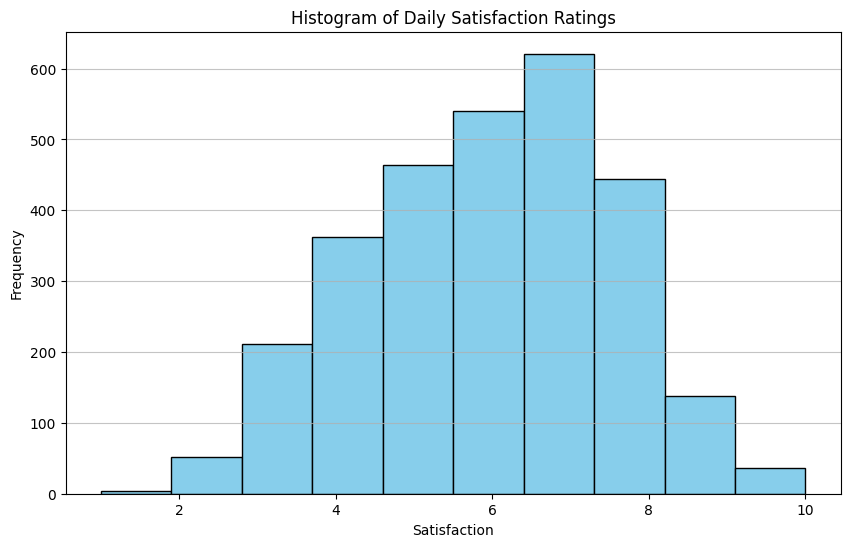

In [1062]:
# Create a histogram of the 'satisfaction' column
plt.figure(figsize=(10, 6))
plt.hist(combined_df['satisfaction'], bins=10, color='skyblue', edgecolor='black')
plt.title('Histogram of Daily Satisfaction Ratings')
plt.xlabel('Satisfaction')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()

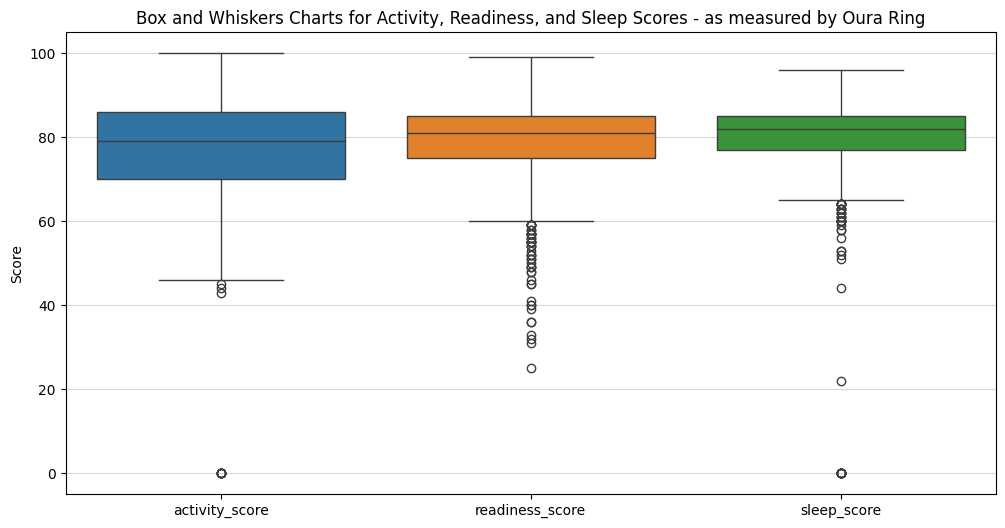

In [1063]:
# Create box and whiskers charts for the specified columns
columns_to_plot = ['activity_score', 'readiness_score', 'sleep_score']

plt.figure(figsize=(12, 6))
sns.boxplot(data=combined_df[columns_to_plot])
plt.title('Box and Whiskers Charts for Activity, Readiness, and Sleep Scores - as measured by Oura Ring')
plt.ylabel('Score')
plt.xticks(ticks=range(len(columns_to_plot)), labels=columns_to_plot)
plt.grid(axis='y', alpha=0.5)
plt.show()

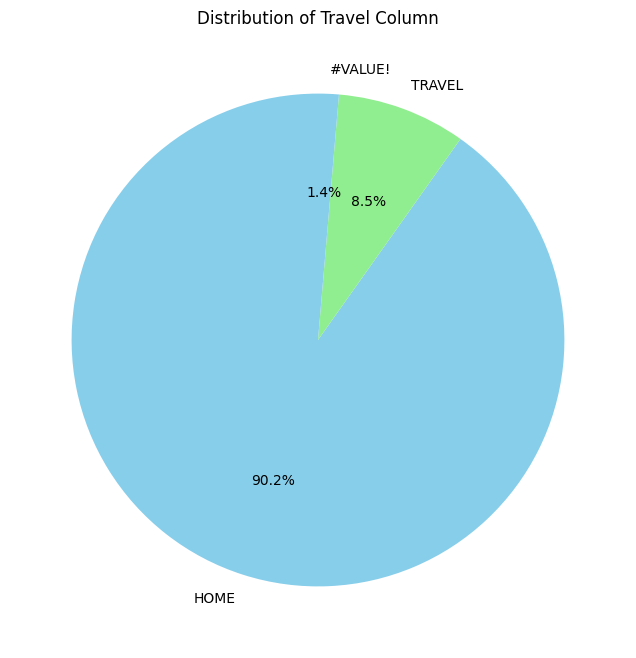

In [1064]:
# Count the occurrences of each value in the 'travel' column
travel_counts = combined_df['travel'].value_counts()

# Create a pie chart
plt.figure(figsize=(8, 8))
plt.pie(travel_counts, labels=travel_counts.index, autopct='%1.1f%%', startangle=90, colors=['skyblue', 'lightgreen'])
plt.title('Distribution of Travel Column')
plt.show()

Ooo found some bad data there. Replacing the `#VALUE!# with blanks.

In [1065]:
# Replace '#VALUE!' in the 'travel' column with blank values (NaN)
combined_df['travel'] = combined_df['travel'].replace('#VALUE!', None)

# Converting what remains to numerical data for ML algorithms
combined_df['travel'] = combined_df['travel'].replace({'HOME': 0, 'TRAVEL': 1})

# Verify the replacement
print(combined_df['travel'].value_counts(dropna=False))

travel
0.0    2592
1.0     243
NaN      39
Name: count, dtype: int64


/var/folders/hk/h6rz0nm939n_y0ssynfrg63r0000gn/T/ipykernel_19397/2141486.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  combined_df['travel'] = combined_df['travel'].replace({'HOME': 0, 'TRAVEL': 1})


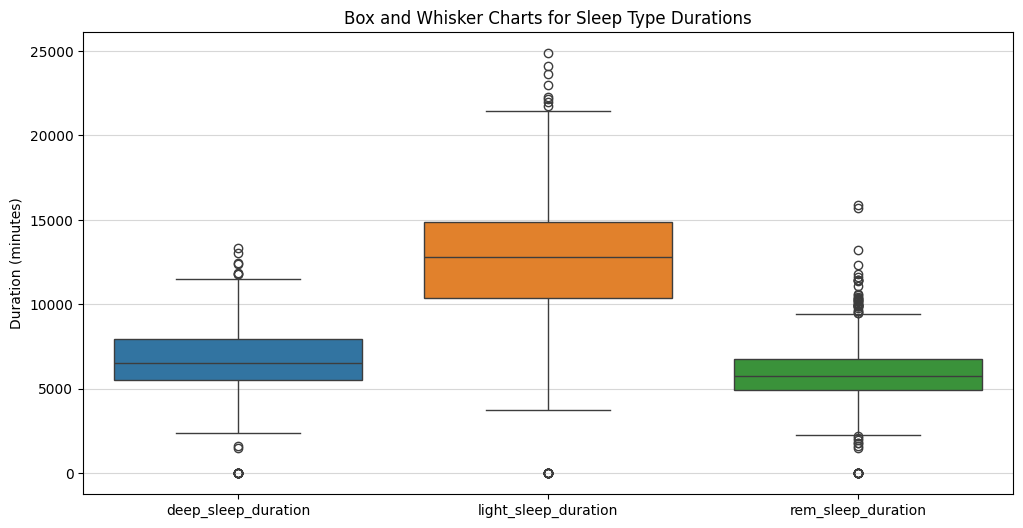

In [1066]:
# Columns to plot
sleep_columns = ['deep_sleep_duration', 'light_sleep_duration', 'rem_sleep_duration']

# Create box and whisker charts
plt.figure(figsize=(12, 6))
sns.boxplot(data=combined_df[sleep_columns])
plt.title('Box and Whisker Charts for Sleep Type Durations')
plt.ylabel('Duration (minutes)')
plt.xticks(ticks=range(len(sleep_columns)), labels=sleep_columns)
plt.grid(axis='y', alpha=0.5)
plt.show()

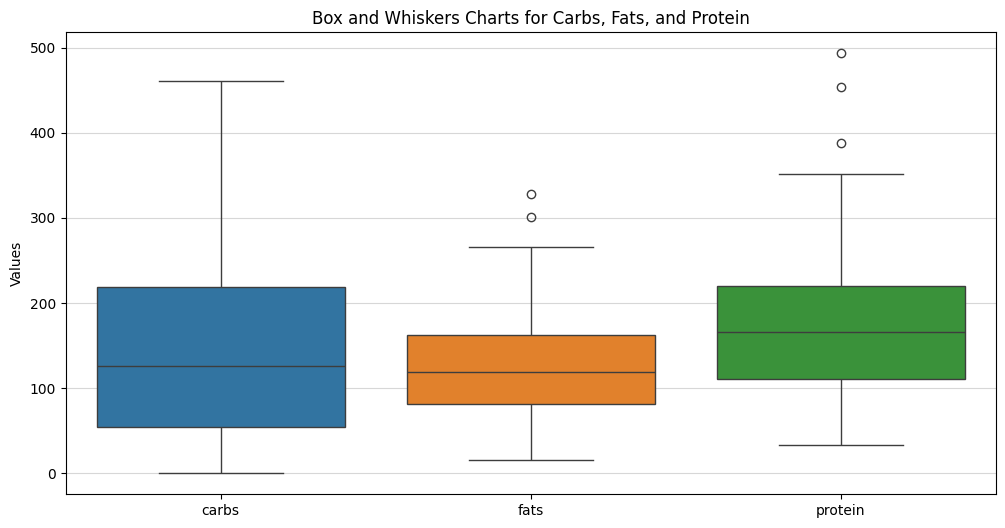

In [1067]:
# Create box and whiskers charts for the specified columns
columns_to_plot_nutrition = ['carbs', 'fats', 'protein']

plt.figure(figsize=(12, 6))
sns.boxplot(data=combined_df[columns_to_plot_nutrition])
plt.title('Box and Whiskers Charts for Carbs, Fats, and Protein')
plt.ylabel('Values')
plt.xticks(ticks=range(len(columns_to_plot_nutrition)), labels=columns_to_plot_nutrition)
plt.grid(axis='y', alpha=0.5)
plt.show()

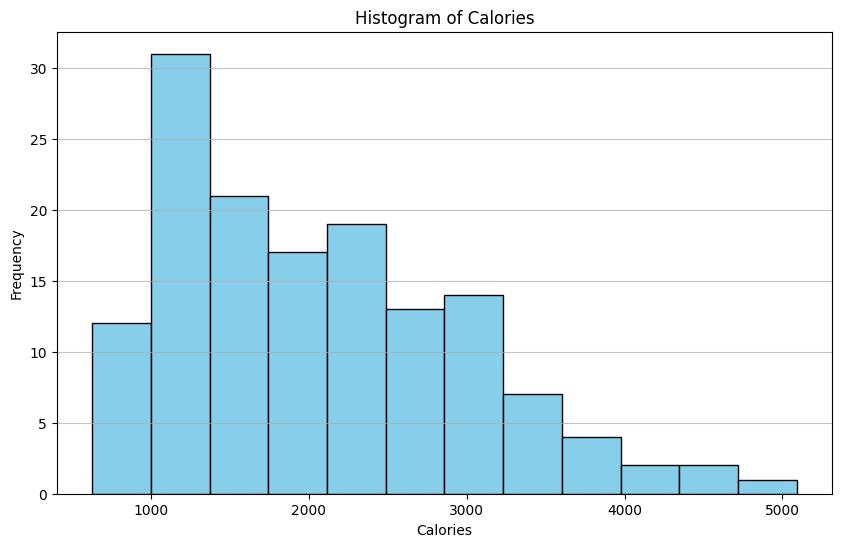

In [1068]:
# Create a histogram for the 'calories' column
plt.figure(figsize=(10, 6))
plt.hist(combined_df['calories'].dropna(), bins=12, color='skyblue', edgecolor='black')
plt.title('Histogram of Calories')
plt.xlabel('Calories')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()

... I don't believe the histogram there. I don't eat 1200 calories more often than 3000. I suspect this is a case of days not being fully-tracked that result in *partial* calorie counts. This is the type of issue that made me write the "don't use the absence of a signal as a signal" principle into existence. The absence of calories in the "Dinner" shouldn't be used as a signal that I didn't actually eat dinner. The Data Journal was meant to combat these issues, but this data isn't sourced through it, rather from Apple Health directly. There's all sorts of confounding issues in the Apple Health data.

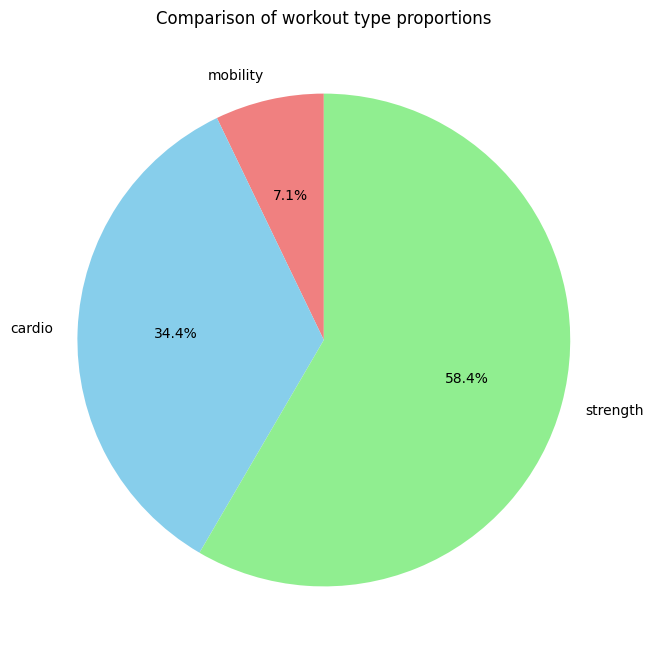

In [1069]:
# Calculate the total for each column
totals = combined_df[['mobility', 'cardio', 'strength']].sum()

# Create a pie chart
plt.figure(figsize=(8, 8))
plt.pie(totals, labels=totals.index, autopct='%1.1f%%', startangle=90, colors=['lightcoral', 'skyblue', 'lightgreen'])
plt.title('Comparison of workout type proportions')
plt.show()

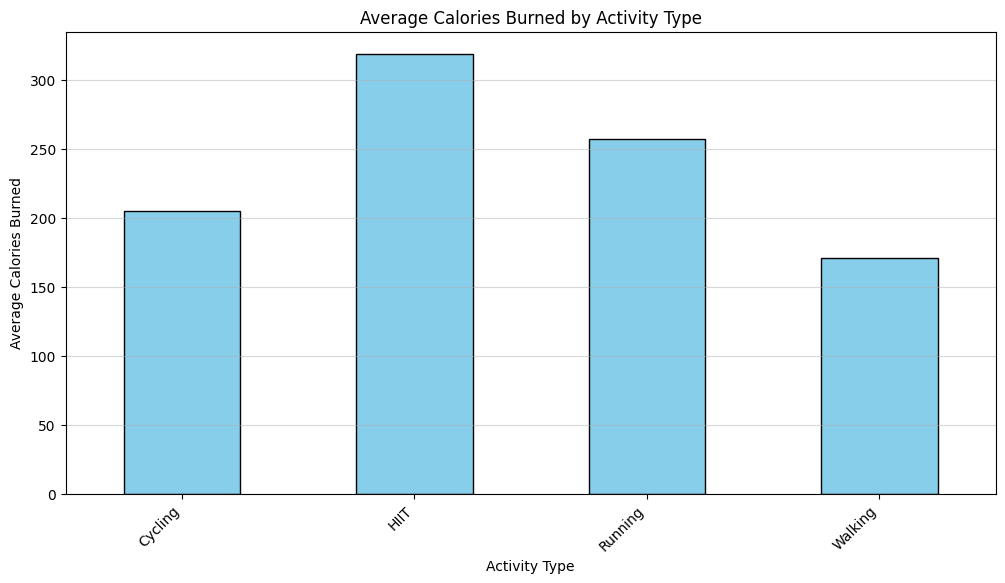

In [1070]:
# Group by 'activitytype' and calculate the mean of 'cals_burned'
activity_avg_cals = combined_df.groupby('activitytype')['cals_burned'].mean().dropna()

# Plot the bar chart
plt.figure(figsize=(12, 6))
activity_avg_cals.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Average Calories Burned by Activity Type')
plt.xlabel('Activity Type')
plt.ylabel('Average Calories Burned')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.5)
plt.show()

For the linear regression, we can't use categorical columns - so let's convert those `activitytype` values to numbers.

In [1071]:
# Convert the 'activitytype' column into numerical data using label encoding
combined_df['activitytype_encoded'] = combined_df['activitytype'].astype('category').cat.codes

# Same with the other couple of categorical columns
combined_df['wk_day_encoded'] = combined_df['wk_day'].astype('category').cat.codes
combined_df['work_status_encoded'] = combined_df['work_status'].astype('category').cat.codes

# Convert the HH:MM:SS for wakeup time to seconds
# Convert to timedelta
combined_df['time_delta'] = pd.to_timedelta(combined_df['wake'])

# Total seconds in a day
seconds_in_day = 24 * 60 * 60

# Calculate proportion of the day
combined_df['wake'] = combined_df['time_delta'].dt.total_seconds() / seconds_in_day

# drop the remaining categorical columns
combined_df = combined_df.drop(columns=['week', 'month', 'quarter', 'activitytype', 'wk_day', 'work_status', 'bedtime'])

> [!important] Dropping sparse columns  
> After doing reflection 2 - I've decided to drop all columns containing less than 500 data points. This includes all of my diet-related columns, unfortunately. 

In [1072]:
# Drop columns with fewer than 500 non-blank values
combined_df = combined_df.dropna(thresh=500, axis=1)

# output the combined dataframe to a CSV file
combined_df.to_csv('output_data/combined_data_encoded.csv', index=False)

# Display the updated dataframe info
print(combined_df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 2874 entries, 0 to 3005
Data columns (total 55 columns):
 #   Column                    Non-Null Count  Dtype          
---  ------                    --------------  -----          
 0   date                      2874 non-null   datetime64[ns] 
 1   active_calories           2132 non-null   float64        
 2   sedentary_time            2132 non-null   float64        
 3   steps                     2132 non-null   float64        
 4   activity_score            2082 non-null   float64        
 5   readiness_score           2076 non-null   float64        
 6   sleep_score               1488 non-null   float64        
 7   temperature_deviation     2076 non-null   float64        
 8   average_breath            1488 non-null   float64        
 9   average_heart_rate        1488 non-null   float64        
 10  average_hrv               1488 non-null   float64        
 11  awake_time                1488 non-null   float64        
 12  deep_sleep_

In [1073]:
# Compute the correlation matrix for the combined dataframe
correlation_matrix = combined_df.corr()

# Extract the correlation of 'satisfaction' with other columns
satisfaction_correlation = correlation_matrix['satisfaction'].sort_values(ascending=False)

# Display the correlation values
# Print all the values without truncation
with pd.option_context('display.max_rows', None):
    print(satisfaction_correlation)

satisfaction                1.000000
active_calories             0.272563
steps                       0.259284
satisfaction_running_avg    0.212375
work_status_encoded         0.194546
health                      0.191653
workouts                    0.161902
saw_friends                 0.124212
strength                    0.121801
alcoholic_drink             0.117295
date_night                  0.110382
activity_score              0.106887
cardio                      0.105959
drinks                      0.095254
efficiency                  0.091605
saw_family                  0.091218
book                        0.079500
activitytype_encoded        0.079322
travel                      0.074959
cals_burned                 0.067276
movie                       0.065778
light_sleep_duration        0.059565
media_count                 0.039985
average_heart_rate          0.039980
sleep_score                 0.038599
latency                     0.036024
outing_count                0.034864
b

In [1074]:
# Drop the 'satisfaction' column from the correlation matrix
correlation_matrix = correlation_matrix.drop(columns=['satisfaction'])

# Display the top 10 and bottom 10 correlations with satisfaction
print("Top 10 correlations with satisfaction:")
print(satisfaction_correlation.head(10))

print("\nBottom 10 correlations with satisfaction:")
print(satisfaction_correlation.tail(10))

Top 10 correlations with satisfaction:
satisfaction                1.000000
active_calories             0.272563
steps                       0.259284
satisfaction_running_avg    0.212375
work_status_encoded         0.194546
health                      0.191653
workouts                    0.161902
saw_friends                 0.124212
strength                    0.121801
alcoholic_drink             0.117295
Name: satisfaction, dtype: float64

Bottom 10 correlations with satisfaction:
time_in_bed             -0.033906
deep_sleep_duration     -0.038273
videogame               -0.048485
days_since_workout      -0.054061
wk_day_encoded          -0.062153
awake_time              -0.070251
lift_volume_lbs         -0.094858
pains                   -0.104191
treatments              -0.106776
temperature_deviation   -0.127460
Name: satisfaction, dtype: float64


### Reflection 2: 

**What patterns or anomalies do you see?**

I've noticed a few anomalies, which were corrected above. Some columns with zeroes where there should have been blanks. The newly added feature "days_since_workout" flagged one streak of 50 days where I didn't record a workout, which I didn't believe. Looking at the source data more, I think there are definitely workouts in there, but they were not actually tracked. That timespan coincides with a source code change that likely caused some issues in capture for a period of time. 

There's also issues with Apple Health data for situations wherein my Apple Watch died, or I couldn't wear it for one reason or another. This happens frequently in my life and leads to days wherein it **looks** like I just didn't take many steps - but in fact a huge swath of the day was simply not counted. There's really nothign to do about this at this stage. Accept the issue and move on.

The most important pattern I see is that **every single datapoint is, at best, weakly correlated with satisfaction**. This does not bode well for high levels of predictive accuracy.

**Do any features stand out?**

Lots stand out. It's easier for me ot say the ones I expect are not that useful - my per-meal-type, per-macronutrient caloric breakdown is... almost certainly not affecting my satisfaction. If there were a correlation there I'd expect it to be reverse-causal. Low satisfaction leading to the urge to snack. 

Immediately I'll be focusing on some of the top-correlated stats.

**What preprocessing steps were necessary to clean and improve the data?** 

Lots. See the steps above.

**Did you create or modify any features to improve performance?**

I did create features based on what I expect should be correlated with satisfaction. I also did some minor modifications to fix data issues here and there. Much of the *real* work was done before the data ever got into this repository when I scrubbed out the things I didn't feel like sharing.


## Section 3. Feature Selection and Justification

I'll be running a large swath of inputs variables against the target variable. Compute is effectively free, there's no reason not to test it all. 

### Y - Satisfaction

My target variable is my daily subjective Satisfaction rating from 1 (horrible day) to 10 (perfect day). 

My target is a **continuous** variable - so the features I'll use to train it must be numeric.

### X - inputs

I'll be running lots of groups of inputs through, hoping to stumble across some unforeseen formula for a perfectly satisfying day. Some groups I know I'll focus on include:

- Most-correlated - things that showed up as the furthest from zero correlation
- Top-level stats - workouts, sleep, and outings. This will give some validity (hopefully) to looking deeper at any of the underlying components in more detail.

Then look in more detail at:
- Exercise - types and frequency
- Sleep - quantity and qualities
- Outings - correlations to columns about date nights, friend dates, etc
  
Finally - hit some miscellaneous checks:
- Oura Scores - Readiness, Sleep, and Activity
- Diet - although I expect low correlation, my diet data quality is lacking
- Exercise Intensity - on days where I burn lots of calories exercising

> [!warning] THIS IS SILLY
> I feel the need to point out here that I don't actually believe the dataset here contain the secrets to living a good life. There is no bound set of data that could actually be optimized to make humans perfectly happy & satisfied with life. While this is all legitimate data, I'm a bit tongue-in-cheek about my goal to find the optimal day. I'll cover this more at the end. 

### Reflection 3: 

Why did you choose these features? 

I chose the target feature because it's the thing that would be, in theory, causally-linked to the inputs. What you do in your life should have a big immpact on how satisfying it is. For the inputs, I've picked several sets that I'm eager to test. They all **could** be very highly linked. Or I could find out nothing I track actually matters and instead it's the price of tea in China that sets my life satisfaction. Who knows!

How might they impact predictions or accuracy?

Exercise regulates emotions and [give you endorphins](https://www.imdb.com/title/tt0250494/quotes/#:~:text=Exercise%20gives%20you%20endorphins). Sleep also helps regulate your mood, and makes life much more difficult when you don't get enough high quality sleep. Outings are what life is made of - going places and doing things with people.  


## Section 4. Train a Model (Linear Regression)

Here's where the rubber meets the road. We'll split the data into **training** and **test** sets.

> [!warning] The training & test data cannot have blanks!
> Because my data have gaps, and those gaps I do not want to fill with arbitrarily-picked "default" data, I'm going to have varying X and Y dataframes depending on what rows the input data have values for.

In [1075]:
model_results_accumulator = {}

# We plan to train and test many variations of the model, so we will create a function to do this
def train_and_test(features, feature_set_name):
    # Filter the dataframe to keep only rows with non-null values in the specified columns
    df_filtered = combined_df.dropna(subset=features)

    # Log the number of rows dropped
    print(f"{len(df_filtered)} rows used out of the possible {len(combined_df)}")

    # Define the features (X) and target (y)
    X = df_filtered.drop(columns=['satisfaction'])
    y = df_filtered['satisfaction']

    # Split the data into training and test sets (80% training, 20% testing)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Select the specified columns for training
    X_train_selected = X_train[features]
    X_test_selected = X_test[features]

    # Initialize the model
    model = LinearRegression()

    # Train the model
    model.fit(X_train_selected, y_train)

    # Display the coefficients and intercept
    print("Coefficients:", model.coef_)
    print("Intercept:", model.intercept_)

    # Test the model and display the R^2 score
    r2_score = model.score(X_test_selected, y_test)
    print("R^2 Score:", r2_score)

    # Calculate Mean Absolute Error
    mae = mean_absolute_error(y_test, model.predict(X_test_selected))
    print("Mean Absolute Error:", mae)

    # Calculate Mean Squared Error
    mse = ((y_test - model.predict(X_test_selected)) ** 2).mean()
    print("Mean Squared Error:", mse)

    # Add the MAE to the model_results_accumulator
    model_results_accumulator[feature_set_name] = mae

# Picking the highest correlating features to train the model, 
single_highest_correlate = ['active_calories']

train_and_test(single_highest_correlate, "single_highest_correlate")

2132 rows used out of the possible 2874
Coefficients: [0.00176575]
Intercept: 4.982664467729575
R^2 Score: 0.07564107002704712
Mean Absolute Error: 1.3973216259364603
Mean Squared Error: 2.849391446242772


## Section 5. Improve the Model or Try Alternatives (Implement Pipelines)

The bar is set - using the most-highly correlated input feature we achieved an Mean Average Error of 1.04. This means we could predict, on average, very close to the real value. If we predict a 5, we expect it would be a 4, 5, or 6 almost 50% of the time.

Let's compare that to simply stating the average each time:

In [1076]:
# Compute the mean of the target column

mean_value = combined_df['satisfaction'].mean()

# Create a baseline prediction where every value is the mean
combined_df['baseline_pred'] = mean_value

# Calculate MAE
baseline_mae = mean_absolute_error(combined_df['satisfaction'], combined_df['baseline_pred'])

print(f"Baseline MAE (predicting the mean): {baseline_mae:.3f}")

model_results_accumulator['JUST_TAKING_THE_AVERAGE'] = baseline_mae

Baseline MAE (predicting the mean): 1.435


So, not given **any** data, we expect to be able to predict the value of `satisfaction` to within 1.435. This makes our 'high score' thus far not seem all that high. 

Let's see if we can do better.

In [1077]:
# Including everything with an absolute correlation greater than 0.1
all_highest_correlates = ['satisfaction_running_avg', 'active_calories', 'steps', 'work_status_encoded','health','workouts','temperature_deviation','treatments','pains','saw_friends','strength','alcoholic_drink','date_night','activity_score','cardio']
train_and_test(all_highest_correlates, "all_highest_correlates")

1885 rows used out of the possible 2874
Coefficients: [ 2.05681311e-01  1.70363724e-04  1.05821593e-04  7.19589097e-02
  8.47313120e-02  6.31513830e-02 -4.43224617e-01 -1.77687725e-01
  2.35411707e-01  7.18193861e-01  3.82043244e-01  1.25685627e-01
  1.93410011e+00 -4.67987525e-03  2.40170960e-01]
Intercept: 3.114180810240749
R^2 Score: 0.11757007022595745
Mean Absolute Error: 1.3001403759726269
Mean Squared Error: 2.577870817509172


In [1078]:
# Looking at a combination of the highest correlating features OTHER THAN the highest-correlate
other_highest_correlates = ['satisfaction_running_avg', 'steps', 'work_status_encoded','health','workouts','temperature_deviation','treatments','pains','saw_friends','strength','alcoholic_drink','date_night','activity_score','cardio']
train_and_test(other_highest_correlates, "other_highest_correlates")

1885 rows used out of the possible 2874
Coefficients: [ 2.05505502e-01  1.16938065e-04  7.17436988e-02  8.57343685e-02
  7.48104902e-02 -4.48952788e-01 -1.76623265e-01  2.38025902e-01
  7.20820919e-01  4.11681538e-01  1.23998820e-01  1.94009659e+00
 -4.34753826e-03  2.52239725e-01]
Intercept: 3.0802061709796273
R^2 Score: 0.1172551408957424
Mean Absolute Error: 1.3007171941177273
Mean Squared Error: 2.578790830648512


In [1079]:
# Top-Level Stats - the things that come to mind that I expected to matter
my_expectations = ['sleep_duration', 'days_since_workout', 'outing_count']
train_and_test(my_expectations, "my_expectations")

1948 rows used out of the possible 2874
Coefficients: [-0.09523899 -0.01795212  0.12414601]
Intercept: 6.75590581936963
R^2 Score: -0.0042697168820171605
Mean Absolute Error: 1.486202929215879
Mean Squared Error: 3.2075952184812686


In [1080]:
# Exercise-related stuff only
exercise_related = ['active_calories', 'steps', 'activity_score', 'workouts','strength','cardio', 'lift_volume_lbs', 'cals_burned']
train_and_test(exercise_related, "exercise_related")

76 rows used out of the possible 2874
Coefficients: [ 3.39516121e-03 -1.44414703e-04  1.43232629e-02  2.32795055e-01
  1.42757442e-01  9.00376136e-02 -1.99430266e-04 -5.32641553e-04]
Intercept: 5.304833332054894
R^2 Score: -0.8865184346225259
Mean Absolute Error: 1.5404718422723307
Mean Squared Error: 4.362573880064591


When taking these sparsely-populated columns in conjunction you start to really reduce the number of valid tuples wherein ALL of the fields contained values. We're down to 76 such days. These are days wherein I tracked weightlifting using my strength training app, AND various other datapoints were also successfully captured.

In [1081]:
# Looking at Sleep data only
sleep_data = ['wake', 'bedtime_wrapped', 'sleep_duration', 'sleep_score', 'total_sleep_duration', 'deep_sleep_duration', 'light_sleep_duration', 'rem_sleep_duration', 'latency', 'efficiency','time_in_bed']
train_and_test(sleep_data, "sleep_data")

1456 rows used out of the possible 2874
Coefficients: [-1.90611621e+00  2.35250983e+00  6.93976591e-02 -3.91574583e-02
  8.70465890e-05 -2.97746125e-06  3.68116740e-05  5.32123548e-05
  1.25381503e-04  1.81346811e-02 -7.17940270e-05]
Intercept: 4.329324140325597
R^2 Score: 0.015930202165285734
Mean Absolute Error: 1.4819679458423811
Mean Squared Error: 3.17707137360376


In [1082]:
# Looking at Oura Scores data only
oura_scores = ['activity_score', 'readiness_score', 'sleep_score']
train_and_test(oura_scores, "oura_scores")

1427 rows used out of the possible 2874
Coefficients: [ 0.01523815 -0.00728151 -0.01229083]
Intercept: 6.46435071923302
R^2 Score: 0.015640640518236437
Mean Absolute Error: 1.4749870295624141
Mean Squared Error: 3.232755709556301


In [1083]:
# Looking a outings only - social events, etc
social_events = ['outing_count', 'saw_friends', 'date_night', 'travel']
train_and_test(social_events, "social_events")

1972 rows used out of the possible 2874
Coefficients: [-0.06001109  0.69909464  1.75669593  0.6456015 ]
Intercept: 5.8413527158679415
R^2 Score: 0.02682165113017332
Mean Absolute Error: 1.4739030847002563
Mean Squared Error: 3.1649674763462454


That pretty well exhausts the simple linear regression using combinations of features. Let's see how they did.

In [1084]:
# Sort the model_results_accumulator dictionary by MAE values in ascending order
sorted_results = sorted(model_results_accumulator.items(), key=lambda x: x[1])

# Print the sorted results
for model_name, mae in sorted_results:
    print(f"{model_name}: {mae:.4f}")

all_highest_correlates: 1.3001
other_highest_correlates: 1.3007
single_highest_correlate: 1.3973
JUST_TAKING_THE_AVERAGE: 1.4355
social_events: 1.4739
oura_scores: 1.4750
sleep_data: 1.4820
my_expectations: 1.4862
exercise_related: 1.5405


> [!TLDR] Only 3 models did better than simply guessing the average `satisfaction` value each time.

### Lasso

In [1085]:
# Preprocess the data to handle incompatible data types
X = combined_df.drop('satisfaction', axis=1)

# Drop columns with datetime or timedelta data types
X = X.select_dtypes(exclude=['datetime64[ns]', 'timedelta64[ns]'])

# Separate the target variable
y = combined_df['satisfaction']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Impute missing values with the mean for numerical columns
X_train = X_train.fillna(X_train.mean())
X_test = X_test.fillna(X_train.mean())

# Initialize and train the Lasso regression model
lasso = Lasso(alpha=0.2)  # You'll need to tune the 'alpha' hyperparameter

# Fit the Lasso regression model
lasso.fit(X_train, y_train)

# Get the coefficients - features with zero coefficient were effectively eliminated
selected_features_lasso = X_train.columns[lasso.coef_ != 0]
print("\nSelected features (Lasso):", selected_features_lasso)

# Evaluate the model
y_pred_lasso = lasso.predict(X_test)
mae_lasso = mean_absolute_error(y_test, y_pred_lasso)
print("Mean Absolute Error (Lasso):", mae_lasso)

model_results_accumulator['Lasso'] = mae_lasso


Selected features (Lasso): Index(['active_calories', 'sedentary_time', 'steps', 'awake_time',
       'deep_sleep_duration', 'latency', 'light_sleep_duration',
       'rem_sleep_duration', 'time_in_bed', 'total_sleep_duration',
       'lift_volume_lbs', 'duration', 'cals_burned', 'day', 'health',
       'satisfaction_running_avg', 'work_status_encoded'],
      dtype='object')
Mean Absolute Error (Lasso): 1.3777254756540047


### Pipeline

In [1086]:


# Define the pipeline
pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),  # Handle missing values
    ('poly_features', PolynomialFeatures(degree=3, include_bias=False)),  # Add polynomial features
    ('scaler', StandardScaler()),  # Standardize the features
    ('linear_regression', LinearRegression())  # Linear regression model
])

# Filter the dataframe to keep only rows with non-null values in the target column
df_filtered = combined_df.dropna(subset=['satisfaction'])

# Define the features (X) and target (y)
# Drop non-numeric columns like 'time_delta' and 'date'
X = df_filtered.drop(columns=['satisfaction', 'time_delta', 'date'])
y = df_filtered['satisfaction']

# Split the data into training and test sets (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit the pipeline on the training data
pipeline.fit(X_train, y_train)

# Predict on the test data
y_pred_scaled = pipeline.predict(X_test)

# --- Calculate MAE ---
mae_pipeline = mean_absolute_error(y_test, y_pred_scaled)
print(f"Mean Absolute Error (Pipeline): {mae_pipeline}")

model_results_accumulator['Pipeline, broken'] = mae_pipeline


Mean Absolute Error (Pipeline): 45806.01803549008


... well that's not helpful. I suspect the issue here is that the values are being scaled, thus the MAE is *also* being scaled. I tried jumping through some hoops to reverse the effects of the scaling, but every attempt resulted in either errors or similarly non-believable/uninterpretable MAEs. So we will just move on.

### Decision Tree

In [1087]:

# Filter the dataframe to keep only rows with non-null values in the target column
df_filtered = combined_df.dropna(subset=['satisfaction'])

# Define the features (X) and target (y)
X = df_filtered.drop(columns=['satisfaction', 'time_delta', 'date'])  # Drop non-numeric and irrelevant columns
y = df_filtered['satisfaction']

# Split the data into training and test sets (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the Decision Tree Regressor
decision_tree = DecisionTreeRegressor(random_state=42)

# Train the model
decision_tree.fit(X_train, y_train)

# Predict on the test set
y_pred = decision_tree.predict(X_test)

# Calculate Mean Absolute Error
mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error (Decision Tree): {mae:.3f}")

model_results_accumulator['Decision Tree'] = mae

Mean Absolute Error (Decision Tree): 1.746


In [1088]:
# Sort the model_results_accumulator dictionary by MAE values in ascending order
sorted_results = sorted(model_results_accumulator.items(), key=lambda x: x[1])

# Print the sorted results
for model_name, mae in sorted_results:
    print(f"{model_name}: {mae:.4f}")

all_highest_correlates: 1.3001
other_highest_correlates: 1.3007
Lasso: 1.3777
single_highest_correlate: 1.3973
JUST_TAKING_THE_AVERAGE: 1.4355
social_events: 1.4739
oura_scores: 1.4750
sleep_data: 1.4820
my_expectations: 1.4862
exercise_related: 1.5405
Decision Tree: 1.7461
Pipeline, broken: 45806.0180


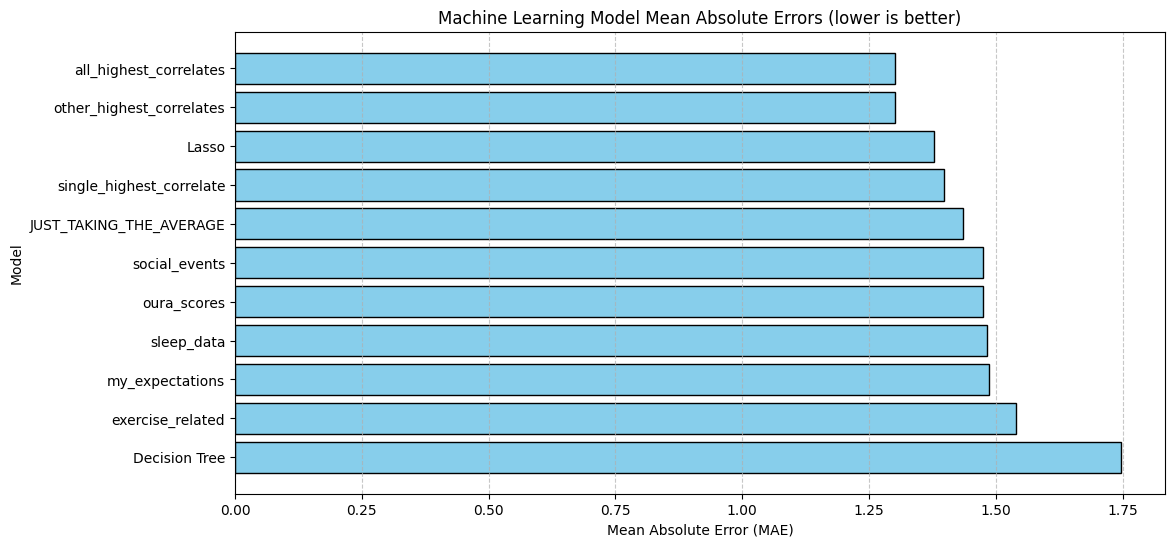

In [1089]:
# Dropping the broken "Pipeline" result from sorted_results
sorted_results = [(name, mae) for name, mae in sorted_results if name != 'Pipeline, broken']

# Extract model names and MAE values from sorted_results
model_names = [item[0] for item in sorted_results]
mae_values = [item[1] for item in sorted_results]

# Create a bar chart
plt.figure(figsize=(12, 6))
plt.barh(model_names, mae_values, color='skyblue', edgecolor='black')
plt.xlabel('Mean Absolute Error (MAE)')
plt.ylabel('Model')
plt.title('Machine Learning Model Mean Absolute Errors (lower is better)')
plt.gca().invert_yaxis()  # Invert y-axis to show the best model at the top
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

### Reflection 5

Which models performed better?

The highest performing model was the linear regression given access to all correlations with a correlation coefficients whose absolute value was greater than 0.1. This model was very nearly capable of predicting the `satisfaction` value to within 1 point (out of 10). After that, the Lasso model performed the best. From there, there was a high drop off. The Decision Tree just barely beat out a flat line guessing the average no matter what. 

How does scaling impact results?

In my case scaling **broke** the results in a way that was not correctable after an hour of troubleshooting. I suspect there's probably more work that could be done to re-constitute and normalize the MAE, but I also suspect the result wouldn't be much better than what I saw across the other models. My underlying dataset simply doesn't capture enough of the inputs that go into making a satisfying life. 

## Section 6. Final Thoughts & Insights

### Summarized Findings

I trained 10 machine learning models to predict my daily subjective `satisfaction` rating (which ranges from 1 to 10). Given 50+ relevant facts about my day, how closely could an ML algorithm come to predicting how satisfying I would rate that day?

The best model, a linear regression model utilizing the **fifteen** most highly-correlated features, was capable of predicting my `satisfaction` to within +/- 1.3 points, on average (MAE = 1.30). This means if the model guessed a `6.0`, we could say with 50% confidence that the real value lay somewhere between `4.7` and `7.3`, inclusive.

While that *sounds* good, this is **not** a highly predictive model. 

Simply predicting the average `satisfaction` value, regardless of all other data, would yield an MAE = 1.44. The 50% confidence interval is `4.56` and `7.44`. Thus, given NO information and simply predicting `satisfaction` = `6.0` every time we'd barely be worse off than using sophisticated machine learning techniques utilizing thousands of datapoints.

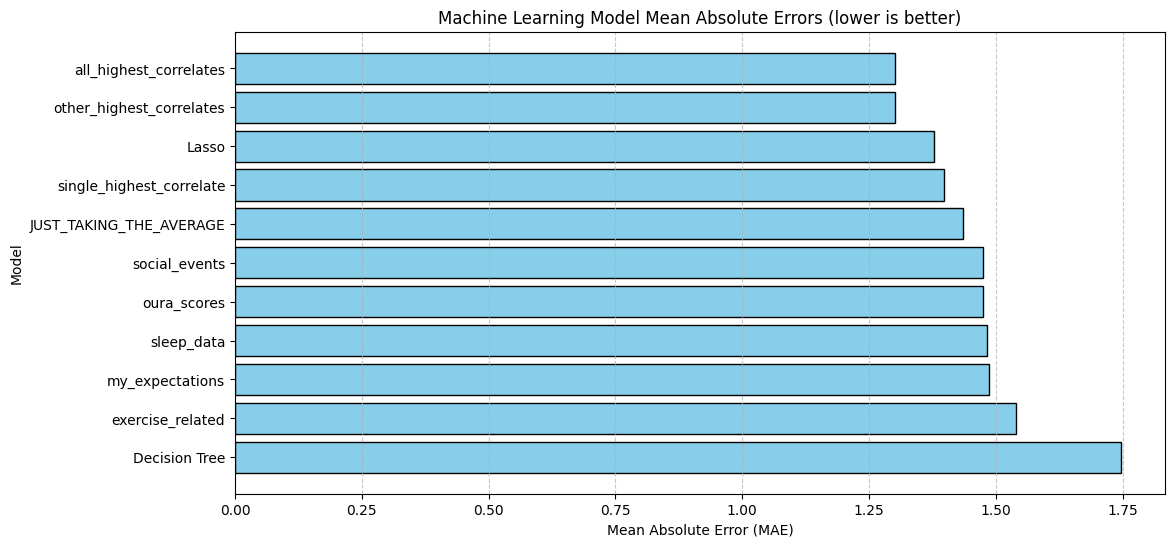

What does this say about life? What does this say about machine learning?

The data features most highly correlated with `satisfaction` were surprising.

1. `active_calories` - from my Oura Ring, [their documentation](https://cloud.ouraring.com/v2/docs#operation/Single_daily_activity_Document_v2_usercollection_daily_activity__document_id__get) says this is a measure of "Active calories expended"
2. `steps` - also Oura Ring, "Total number of steps taken", which would correlate highly with #1 
3. `satisfaction_running_avg` - looking at the previous 3 days to make your prediction about today
4. `work_status_endocded` - weekends are generally more satisfying
5. `health` - my subjective health rating, 1 to 10, made at the same time I do the `satisfaction` rating

All of those were positively correlated with increased `satisfaction`. Interestingly, **nothing** in the top 5 has to do with sleep, actual *workouts* (as opposed to generic activity), and/or social outings. 

The predictive power considering the strongest *negative* correlates were lower than the positive correlates. The most negatively correlated features were:

1. `temperature_deviation` - from my Oura Ring, "Temperature deviation in degrees Celsius." - I believe during sleep, indicating some fluntuation in health and metabolism.
2. `treatments` - indicating some form of medication or physical therapy took place
3. `pains` - indicating something hurt enough to warrant tracking, almost 1:1 with `treatments`
4. `lift_volume_lbs` - one of the most surprising contraindications here, when I lift MORE, I feel less satisfied
5. `awake_time` - from my Oura Ring, time spent *awake* while trying to sleep the night before

> [!tldr] If you want to be more satisfied: try to move more and work and be sick less...  
> ...but there's not much you can do to "hone" `satisfaction` levels using what's tracked here.

You can track dozens of datapoints about your life, but that doesn't make your subjective **life satisfaction** a highly-preditable phenomenon.

Machine Learning is an **awesome technique**. It can be used to reliably predict the weather many days from now using phenomenon observed today... but it's not capable of devining results in a low-vailidity environment, such as the highly abstract nature of life satisfaction.


### Challenges Faced

The biggest challenge faced was trying to compare scaled data against unscaled data. I tried re-normalizing the post-scaling-pipeline results to no avail. I did look at the R^2 value, expecting that it might be better, but it, too, showed the effects of scaling. This is the only part of the project I walk away disppointed by. 

Other challenges included the relatively small variance in the dataset `satisfaction` value. Simply taking the average as your prediction is a **pretty good prediction**. Making meaningful improvements on it is hard. Most predictive models did essentially only as good as taking the average.

I ran into an issue late in the analysis in which I realized the `satisfaction_running_avg` was not offset, thus it was including the predictive target in its computation. That caused it to have inflated predictive power in a manner that wouldn't actually be possible for predicting *future* results (i.e., the value of the actual result would be an implicit input to the prediction itself). I solved this by offsetting the running average, but that made the already not super predictive model even less impressive. :-P 

### If I Had More Time, Next I'd Try...

If I had more time, I'd like to do several bits of analysis:

- **Add more memory-including columns**. Right now the only columns that reflect values dependent on previous days are the `satisfaction_running_avg` and `days_since_workout` columns. I think, in particular, the **sleep** metrics have a tendency to accumulate to meaningful impacts. Also, consequtive `pains` and/or `treatments` would indicate some form of illness or injury that's affectng me day-over-day.
- **Step up in scale to analyze weeks**. I think that summing up and/or averaging most datapoints to the level of *weeks* would stablize some noise, and perhaps start to make for clearer signals. Trends are definitely easier to see at that level. I do suspect, though, that the standard variation about the `satisfaction` average would drop significantly, and we'd have a very small range in which our predictions could reasonably fall. 
- **Drawing out more plots**. I didn't include as many graphics as I would have liked.

### Reflection 6 

What did you learn from this project?

Numerous things! 

- I learned that sparse data combine to become even more sparely-populated data. The combination of several features that each had 500+ values came together to produce only ~80 usable rows for the model.
- I learned that Lasso models aren't strictly better than linear regressions, which I had previously suspected to be true.
- I learned lots about life satisfaction & my Data Journal and other quantified-self habits. Those are covered above.

### Future Work - Extensions

While my dataset is extensive, it's missing all sorts of things I'd *like* for it to have. 

- **Productivity & Goals** - there is nothing in my dataset to do with the fulfillment of goals, which I find very satisfying. At points in the past I've tried tracking activity completion, but I ceased after I realized I was moreso tracking *engagement with my task management system* rather than actual *productivity*. There's just no objective way to measure something like "importance". I strive to do *important* things, not *lots of things*.
- **Diet** - While I **do** have some calories and macronutriet data, I do not have many factors relevant to a healthy life, such as the level of processing that went into the food.
- **Biomarkers** - in particular blood sugar from a continuous glucose monitor
- **Photos** - I'd like to run all my photos through a classification model & have data about the contents of said photos, who am I taking photos of, what settings, etc
- **Natural Language Processing** - this is full down-the-rabbit-hole territory, but it would be neat to see sentiments pulled from [my personal blog](https://aarongilly.com), the volume of [my public-facing notes](https://gillespedia.com), etc.
- **Experience Sampling** - perhaps the **greatest flaw of all** if I were to be treating this as a serious study in trying to maximize the `satisfaction` levels of my life is that I only rate satisfaction once per day, at the end of the day. I'd have a better dataset if I were randomly polled ~5 to 10 times throughout the day for "satisfaction" scores. This would help get the input of the **experiencing self**, which Daniel Kahneman suggests is a different person than the **remembering self**. 